In [43]:
# Libraries
using ScikitLearn;
using DataFrames;
using CSV;
using Random;
using Statistics;
using StatsPlots;
using Flux.Losses;
using Flux;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculation and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

# Hold-out partition

In [44]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

# Imputation

In [45]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [10]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

# Helper function for finding best performing model

In [46]:
function findBestModel(models, trainInputs, trainTargets, kFoldIndices)
    bestMetricYet = 0;
    bestModel = -1;
    
    for (modelType, paramList) in models
        cnt = 1;
        println();
        println("Training ", modelType, " models:");
        for params in paramList
            (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                          trainTargets, kFoldIndices);
            println("Configuration ", cnt);
            println("Accuracy:", accur, ", stdDev:", stdAccur);
            println("F1-Score:", fScore, ", stdDev:", stdFScore);
            println();
            cnt += 1;
            #println(modelType, (accur, fScore), (stdAccur, stdFScore))
            if accur * fScore > bestMetricYet
                bestMetricYet = accur * fScore;
                bestModel = (modelType, params);
            end;
        end;
    end;
    
    return bestModel
end;

# Categorical approach

In [47]:
trainTargets = Array(support2[trainIndex, "fate"]);
testTargets = Array(support2[testIndex, "fate"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

- ANN

In [48]:
ANNparams = [Dict("topology" => [3, 8], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [6, 16], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:
Configuration 1
Accuracy:0.744232570368976, stdDev:0.024561088235282365
F1-Score:0.7313936175936341, stdDev:0.03296228658933904

Best model is ANN with hyperparameters:
Dict{String, Any}("maxEpochs" => 100, "learningRate" => 0.01, "topology" => [3, 8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)


- SVM

In [ ]:
SVMparams = [Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "rbf", "degree" => 3, "gamma" => 30, "C" => 1), # higher gamma
            Dict("kernel" => "sigmoid", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 6, "gamma" => 2, "C" => 1)] # higher degree

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);

Training SVM models:
Configuration 1
Accuracy:0.8527547846531401, stdDev:0.010729735746110348
F1-Score:0.4624274112712278, stdDev:0.19361449988276466

Configuration 2
Accuracy:0.72765260331163, stdDev:0.022031761199192295
F1-Score:0.3790720191435945, stdDev:0.25405276161536156

Configuration 3

- DecisionTree

In [39]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1
Accuracy:0.8203744784542707, stdDev:0.011695746437222264
F1-Score:0.8153412479490786, stdDev:0.012678305814078071

Configuration 2
Accuracy:0.8225836484638108, stdDev:0.010894809626694108
F1-Score:0.8207646239302677, stdDev:0.010593751646401394

Configuration 3
Accuracy:0.7895062508860051, stdDev:0.010223076525427342
F1-Score:0.7891874565814502, stdDev:0.010140548279916124

Best model is DTree with hyperparameters:
Dict("maxDepth" => 8)


- KNN

In [8]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1
Accuracy:0.7675055887344995, stdDev:0.017544684925476884
F1-Score:0.7666030787135351, stdDev:0.017682985853871534

Configuration 2
Accuracy:0.7872953000169017, stdDev:0.011411894739570197
F1-Score:0.7862048793141947, stdDev:0.011385734127817657

Configuration 3
Accuracy:0.789231197769446, stdDev:0.010935732595464044
F1-Score:0.787848939956688, stdDev:0.011243929454209866

Best model is KNN with hyperparameters:
Dict("k" => 12)


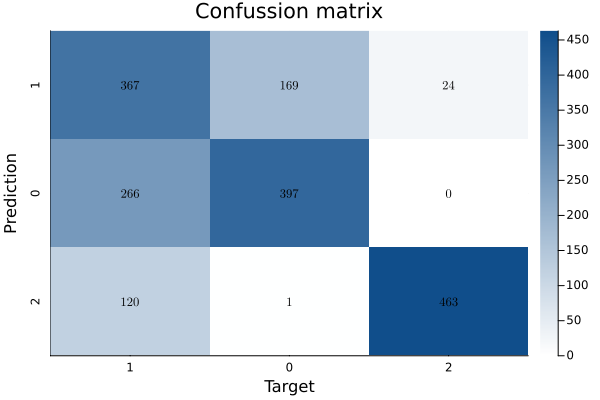

In [49]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

displayConfMat(confMat, classes)

- Ensemble

In [37]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 8)
KNNparams = Dict("k" => 6)
SVMparams = Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

means, stds = trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5))

println("Mean accuracy and F-Score: ", means)
println("Standard deviations in accuracy and F-Score: ", stds)

Mean accuracy and F-Score: 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7bf2fab88c20>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

[0.25435991157189763 0.1083608670074343]
Standard deviations in accuracy and F-Score: [0.0019064343587810704 0.002277159196437568]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7bf2fabd3880>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

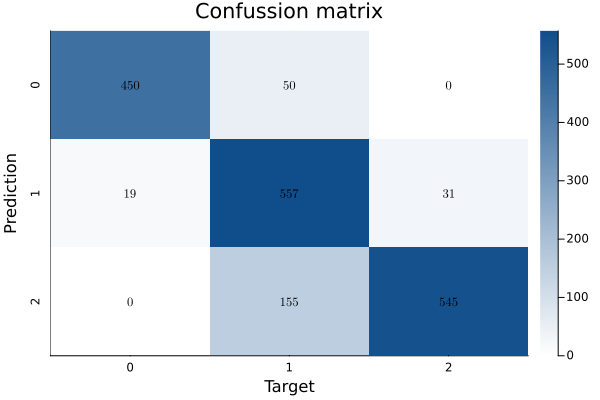

In [38]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

ensemble = fitEnsemble(train, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testInputs), testTargets; weighted=true)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

displayConfMat(confMat, classes)

In [ ]:
# DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16)]

# KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12)]

# SVMparams = [Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "rbf", "degree" => 3, "gamma" => 30, "C" => 1), # higher gamma
#             Dict("kernel" => "sigmoid", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "poly", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "poly", "degree" => 6, "gamma" => 2, "C" => 1)] # higher degree

# ANNparams = [Dict("topology" => [3, 8], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1),
#             Dict("topology" => [6, 16], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1),
#             Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1)]

# models = [(:KNN, KNNparams),(:DTree, DTreeParams),(:SVM, SVMparams),(:ANN, ANNparams)]